## XModalix Workbook

#### IMPORTS

In [1]:
import os
from autoencodix.utils.default_config import DataConfig, DataInfo, DefaultConfig
import autoencodix as acx

notebook_dir = os.path.dirname(os.path.abspath("__file__"))
print(notebook_dir)
os.chdir(notebook_dir)
os.chdir("..")
print(os.getcwd())


/home/ewald/Github/autoencodix_package/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


/home/ewald/Github/autoencodix_package/notebooks
/home/ewald/Github/autoencodix_package


#### GLOBALS
**ATTENTION**
Be sure to have the appropriate files, or adjust paths and make your own config

In [2]:
IMGROOT = os.path.join("data/images/ALY-2_SYS721/")
IMGMAPPING = os.path.join("data/ALY-2_SYS721_mappings.txt")
NUMFILE = os.path.join("data/AM3_NO2_raw_cell.tsv")

img_config = DefaultConfig(
    checkpoint_interval=25,
	loss_reduction = "sum",
    class_param="early",
    epochs=200,
    pretrain_epochs=0,
	beta = 0.01,
	gamma= 2,
	delta_class= 0.0,
	delta_pair = 3,
	learning_rate=0.001,
	k_filter=1000,
	latent_dim=32,
    batch_size=32,
	anneal_pretraining=True,
    data_config=DataConfig(
        data_info={
            "IMG": DataInfo(
                file_path=IMGROOT,
                data_type="IMG",
				scaling="MINMAX",
                translate_direction="to",
                pretrain_epochs=100
            ),
            "RNA": DataInfo(
                file_path=NUMFILE,
                data_type="NUMERIC",
				scaling = "MINMAX",
                translate_direction="from",
            ),
            "RNA2": DataInfo(
                file_path=NUMFILE,
                data_type="NUMERIC",
            ),
            "ANNO": DataInfo(
                file_path=IMGMAPPING,
                data_type="ANNOTATION",
            ),
        },
    ),
)

### Run Xmodalix with defined config
- .run() does not work yet, because we dont have a visualizer, so we run it step by step

In [3]:
%env CUBLAS_WORKSPACE_CONFIG=:16:8

env: CUBLAS_WORKSPACE_CONFIG=:16:8


In [4]:
xmodalix = acx.XModalix(config=img_config)
xmodalix.preprocess()
xmodalix.fit()
result = xmodalix.predict()

preprocessing
Checking data type: IMG
Found image type in config
current data info: file_path='data/images/ALY-2_SYS721/' data_type='IMG' scaling='MINMAX' filtering='VAR' sep=None extra_anno_file=None is_single_cell=False min_cells=0.05 min_genes=0.02 selected_layers=['X'] is_X=False normalize_counts=True log_transform=True k_filter=20 img_root=None img_width_resize=64 img_height_resize=64 translate_direction='to' pretrain_epochs=100
Checking data type: RNA
Checking data type: RNA2
Checking data type: ANNO
Given image size is possible, rescaling images to: 64x64
reading annotation file: data/ALY-2_SYS721_mappings.txt


/home/ewald/Github/autoencodix_package/src/autoencodix/utils/_imgreader.py:251: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support sep=None with delim_whitespace=False; you can avoid this warning by specifying engine='python'.
  annotation = pd.read_csv(anno_file, sep=sep)
/home/ewald/Github/autoencodix_package/src/autoencodix/data/_filter.py:92: UserWarning: WARNING: k is None or greater than number of columns, keeping all features.
  warnings.warn(
/home/ewald/Github/autoencodix_package/src/autoencodix/data/_filter.py:92: UserWarning: WARNING: k is None or greater than number of columns, keeping all features.
  warnings.warn(


 n_samples: {'multi_sc': {'multi_sc': 0}, 'multi_bulk': {'RNA': 260, 'RNA2': 260}, 'annotation': {'paired': 260}, 'img': {'IMG': 260}, 'from_modality': {}, 'to_modality': {}, 'paired_count': {'paired_count': 260}}
Converting 182 images to torch.float32 tensors...
Converting 52 images to torch.float32 tensors...
Converting 26 images to torch.float32 tensors...
key: train, type: <class 'dict'>
key: valid, type: <class 'dict'>
key: test, type: <class 'dict'>
Check if we need to pretrain: multi_bulk.RNA
pretrain epochs : 0
No pretraining for multi_bulk.RNA
Check if we need to pretrain: multi_bulk.RNA2
pretrain epochs : 0
No pretraining for multi_bulk.RNA2
Check if we need to pretrain: img.IMG
pretrain epochs : 100
Starting Pretraining for: img.IMG with <class 'autoencodix.trainers._general_trainer.GeneralTrainer'>
Epoch 1 - Train Loss: 86417.8584
Sub-losses: recon_loss: 86417.4473, var_loss: 906211.9135, anneal_factor: 0.0000, effective_beta_factor: 0.0000
Epoch 1 - Valid Loss: 12938.6182


### Loading and Saving XModalix
- works like for other pipelines too, can be used to run another predict pairing also

In [5]:
xmodalix.save("xmodalix.pkl")

Pipeline object saved successfully.
Preprocessor saved successfully.
Model state saved successfully.


In [6]:
xmodalix = acx.XModalix.load("xmodalix.pkl")

Attempting to load a pipeline from xmodalix.pkl...
Pipeline object loaded successfully. Actual type: XModalix
Preprocessor loaded successfully.
Model state loaded successfully.


### Inspect X-Modalix Result

In [7]:
r = xmodalix.result


Trainingdynamics in result are a dict with keys for each datamodality, the get interface works like for the other pipelines.
We have the special keys:
- translation which is the actual translated reconstruction or the from_latent space for the latentspace dynamic

In [8]:
r.reconstructions.get(epoch=-1, split="test").keys()

dict_keys(['multi_bulk.RNA', 'multi_bulk.RNA2', 'img.IMG', 'translation', 'reference_img.IMG_to_img.IMG'])

We have latentspaces for the test set for each modality, not only for the translation pairing

In [9]:
r.latentspaces.get(epoch=-1, split="test")

{'multi_bulk.RNA': array([[ 0.7581946 ,  0.79176545, -0.2788032 , ...,  4.202005  ,
          1.256395  ,  5.640069  ],
        [-1.1756848 ,  3.2114692 ,  1.5776949 , ...,  1.3444171 ,
          1.178642  , -0.42946598],
        [-0.4672803 , -0.7790553 , -0.712742  , ...,  1.4340143 ,
         -0.27168396,  3.4197328 ],
        ...,
        [ 0.7887805 ,  1.163928  ,  1.1216087 , ...,  1.8116298 ,
          1.3439429 ,  1.7342819 ],
        [-0.79219836,  1.7938697 ,  0.10313956, ...,  3.9290621 ,
          1.9564096 ,  5.579607  ],
        [ 0.5313114 ,  0.15939927, -0.6193494 , ...,  0.25894773,
         -1.2648275 ,  3.9122412 ]], dtype=float32),
 'multi_bulk.RNA2': array([[ 1.1775603 ,  4.1144047 , -0.9448278 , ...,  5.101585  ,
          0.52772397,  5.917579  ],
        [-0.5804931 ,  4.6742187 ,  3.8672967 , ...,  0.13527727,
          0.2611032 ,  0.7890727 ],
        [ 0.38409296, -0.5904398 , -0.713974  , ..., -0.03936148,
          0.6105159 ,  2.1184185 ],
        ...,
  

We also provide the andata interface for the translate latentspace (from_modality)

In [10]:
r.adata_latent.obs_names

Index(['T_236', 'T_98', 'T_182', 'T_191', 'T_251', 'T_217', 'T_183', 'T_219',
       'T_109', 'T_44', 'T_178', 'T_122', 'T_48', 'T_69', 'T_104', 'T_230',
       'T_108', 'T_187', 'T_201', 'T_79', 'T_78', 'T_97', 'T_114', 'T_206',
       'T_235', 'T_203', 'T_193', 'T_119', 'T_88', 'T_156', 'T_132', 'T_144',
       'T_170', 'T_146', 'T_182', 'T_98', 'T_216', 'T_251', 'T_217', 'T_221',
       'T_219', 'T_95', 'T_122', 'T_71', 'T_48', 'T_32', 'T_69', 'T_104',
       'T_146', 'T_108', 'T_47', 'T_201', 'T_157', 'T_28', 'T_97', 'T_150',
       'T_42', 'T_114', 'T_253', 'T_72', 'T_242', 'T_204', 'T_156', 'T_106',
       'T_149', 'T_3', 'T_220', 'T_236', 'T_98', 'T_216', 'T_191', 'T_251',
       'T_217', 'T_221', 'T_109', 'T_44', 'T_122', 'T_32', 'T_47', 'T_28',
       'T_157', 'T_78', 'T_150', 'T_42', 'T_206', 'T_235', 'T_253', 'T_242',
       'T_119', 'T_203', 'T_193', 'T_156', 'T_132', 'T_106', 'T_149', 'T_3',
       'T_170'],
      dtype='object')

And we also support the final_reconstruction attribute that returns the same datastructure as the input data, but switches the actual data with the translated reconstruction (for the translted modality, the rest is the same as the input data)

In [11]:
final_rec = r.final_reconstruction.datasets["img.IMG"]
inputimg = xmodalix.result.datasets.test.datasets["img.IMG"]

## Vis 2D aligned latent development

In [12]:
## from old autoecodix framework
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

def plot_translate_latent(
    # cfg, -> removed
    embedding,
    color_param,
    style_param=None,
    save_fig="",
):
    """
    Creates a 2D visualization of the 2D embedding of the latent space.
    ARGS:
        cfg (dict): config dictionary
        embedding (pd.DataFrame): embedding on which is visualized. Assumes prior 2D dimension reduction.
        color_param (str): Clinical parameter to color scatter plot
        style_param (str): Parameter e.g. "Translate" to facet scatter plot
        save_fig (str): File path for saving the plot. Use appropriate file
                        endings to specify image type (e.g. '*.png')
    RETURNS:
        fig (seaborn.FacetGrid): Figure handle

    """
    labels = embedding[color_param]
    # logger = getlogger(cfg)
    numeric = False
    if not (type(labels[0]) is str):
        if len(np.unique(labels)) > 3:
            # if not cfg["PLOT_NUMERIC"]:
            # print(
            #     f"The provided label column is numeric and converted to categories."
            # )
            # labels = pd.qcut(
            #     labels, q=4, labels=["1stQ", "2ndQ", "3rdQ", "4thQ"]
            # ).astype(str)
            # else:
            numeric = True
        else:
            labels = [str(x) for x in labels]

    # check if label or embedding is longerm and duplicate the shorter one
    if len(labels) < embedding.shape[0]:
        print(
            "Given labels do not have the same length as given sample size. Labels will be duplicated."
        )
        labels = [
            label for label in labels for _ in range(embedding.shape[0] // len(labels))
        ]
    elif len(labels) > embedding.shape[0]:
        labels = list(set(labels))

    if not style_param == None:
        embedding[color_param] = labels
        if numeric:
            palette = "bwr"
        else:
            palette = None
        plot = sns.relplot(
            data=embedding,
            x="DIM1",
            y="DIM2",
            hue=color_param,
            palette=palette,
            col=style_param,
            style=style_param,
            markers=True,
            alpha=0.4,
            ec="black",
            height=10,
            aspect=1,
            s=150,
        )

    if len(save_fig) > 0:
        plot.savefig(save_fig, bbox_inches="tight")

    return plot

In [13]:
## Collect all metadata and latent spaces from datasets
clin_data = []
latent_data = []

for split in ["train", "test", "valid"]:
	split_ds = getattr(r.datasets, split, None)
	if split_ds is not None:
		for key, ds in split_ds.datasets.items():
			df_latent = r.get_latent_df(epoch=-1, split=split, modality=key)
			df_latent["modality"] = key
			df_latent["sample_ids"] = df_latent.index # Each sample can occur multiple times in latent space
			latent_data.append(df_latent)
			if hasattr(ds, "metadata") and ds.metadata is not None:
				df = ds.metadata.copy()
				# Add sample_ids as a column if it's the index
				if df.index.name == "sample_ids" or "sample_ids" not in df.columns:
					df = df.reset_index()
				df["split"] = split
				df["modality"] = key
				clin_data.append(df)

if latent_data and clin_data:
	latent_data = pd.concat(latent_data, axis=0, ignore_index=True)
	clin_data = pd.concat(clin_data, axis=0, ignore_index=True)
	if "sample_ids" in clin_data.columns:
		clin_data = clin_data.drop_duplicates(subset="sample_ids").set_index("sample_ids")
else:
	latent_data = pd.DataFrame()
	clin_data = pd.DataFrame()

In [14]:
from umap import UMAP
param = "split"

## Make 2D Embedding with UMAP
if latent_data.drop(columns=["sample_ids", "modality"]).shape[1] > 2:
	reducer = UMAP(n_components=2)
	embedding = pd.DataFrame(reducer.fit_transform(latent_data.drop(columns=["sample_ids", "modality"])))
	embedding.columns = ["DIM1", "DIM2"]
	embedding["sample_ids"] = latent_data["sample_ids"]
	embedding["modality"] = latent_data["modality"]
	# Merge with clinical data via sample_ids
	embedding = embedding.merge(clin_data.drop(columns=["modality"]), on="sample_ids", how="left")
else:
	embedding = latent_data

embedding

/home/ewald/Github/autoencodix_package/.venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


,DIM1,DIM2,sample_ids,modality,img_paths,extra_class_labels,early,split
0,4.329283,13.047606,T_181,multi_bulk.RNA,ALY-2_SYS721_t181.tif,181,'0',train
1,1.898183,11.794722,T_243,multi_bulk.RNA,ALY-2_SYS721_t243.tif,243,'0',train
2,5.958275,8.911419,T_24,multi_bulk.RNA,ALY-2_SYS721_t24.tif,24,'1',train
3,2.335232,12.090668,T_194,multi_bulk.RNA,ALY-2_SYS721_t194.tif,194,'0',train
4,3.268769,12.474034,T_208,multi_bulk.RNA,ALY-2_SYS721_t208.tif,208,'0',train
...,...,...,...,...,...,...,...,...
1678,6.409154,10.532688,T_119,img.IMG,ALY-2_SYS721_t119.tif,119,'0',test
1679,3.618483,11.920098,T_193,img.IMG,ALY-2_SYS721_t193.tif,193,'0',test
1680,4.021397,8.469173,T_135,img.IMG,ALY-2_SYS721_t135.tif,135,'0',train
1681,9.496544,13.617960,T_14,img.IMG,ALY-2_SYS721_t14.tif,14,'1',train


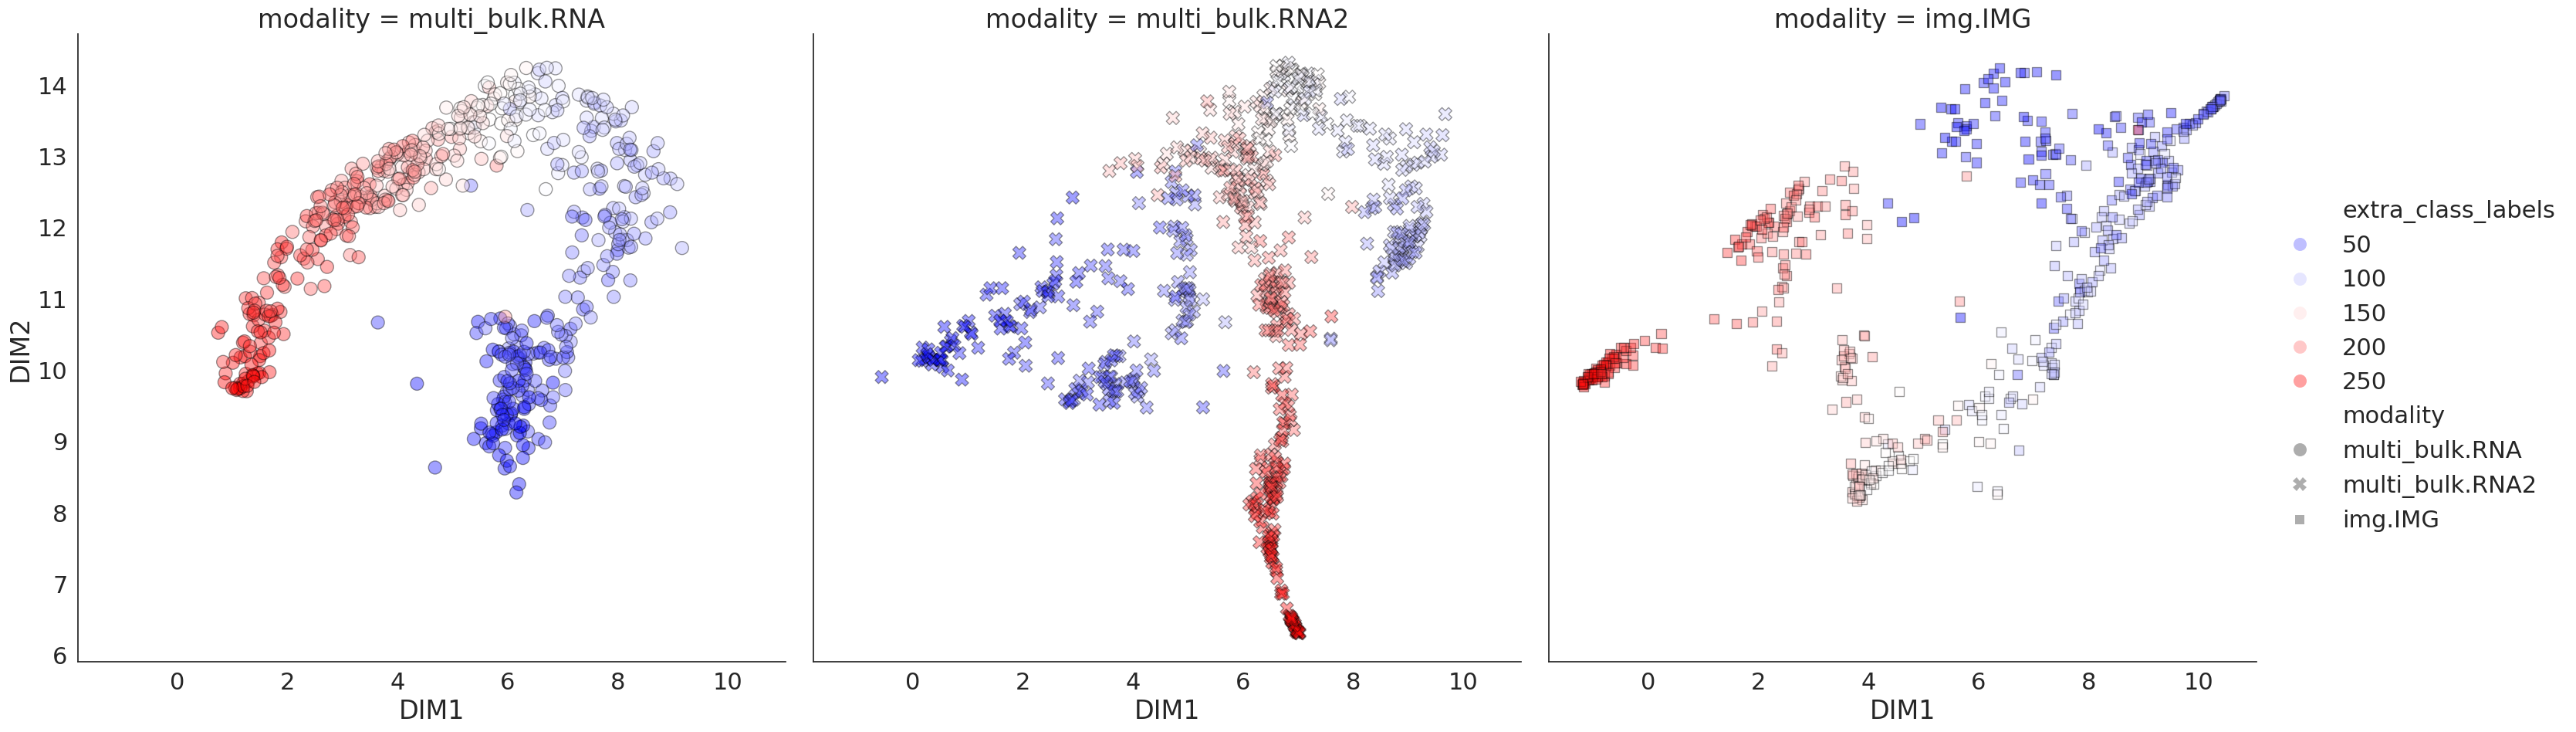

In [15]:
param = "extra_class_labels"
sns.set_theme(font_scale=2)
sns.set_style("white")

plot = plot_translate_latent(
	embedding=embedding,
	color_param=param,
	style_param="modality",
)

## Vis (new) Ridgeline alignment -> ridge per data modality, not grouped by clinic param

## Vis Loss plot absolute and relative

## Vis translate Grid (image case)

### Flexible Prediction
We train the Xmodalix with multiple data modalities, out of all these modalities, we can build any pair for translation byt passing the keys (as defined in your config or datapackage) to the predict method like:

In [16]:
result2 = xmodalix.predict(from_key="IMG", to_key="IMG")

Prediction complete.
Processing latent space results into a single AnnData object...
Identified source modality for latent space: 'multi_bulk.RNA'
  - Added 279 source feature IDs to .uns
Finished processing latent results.


### Inspecting losses
We save all losses in our result object, see the keys here:

In [17]:
result.sub_losses.keys()

dict_keys(['total_loss', 'adver_loss', 'aggregated_sub_losses', 'paired_loss', 'class_loss', 'multi_bulk.RNA.recon_loss', 'multi_bulk.RNA.var_loss', 'multi_bulk.RNA.anneal_factor', 'multi_bulk.RNA.effective_beta_factor', 'multi_bulk.RNA.loss', 'multi_bulk.RNA2.recon_loss', 'multi_bulk.RNA2.var_loss', 'multi_bulk.RNA2.anneal_factor', 'multi_bulk.RNA2.effective_beta_factor', 'multi_bulk.RNA2.loss', 'img.IMG.recon_loss', 'img.IMG.var_loss', 'img.IMG.anneal_factor', 'img.IMG.effective_beta_factor', 'img.IMG.loss', 'clf_loss'])

After selecting a subloss, this works like a standard TrainingDynamic

In [18]:
result.sub_losses.get("adver_loss")

TrainingDynamics()

### Visualizing a sample output
Note this is shown with only one epoch training, I've seen good results for 20 epochs of pretraining img and 30 epochs of normal training

In [19]:
img = result.reconstructions.get(split="test", epoch=-1)

In [20]:
img = img["translation"]

In [21]:
img.shape

(97, 1, 64, 64)

In [22]:
sample_img = img[0, :, :, :].squeeze()
sample_img.shape

(64, 64)

In [23]:
sample_img.max()

np.float32(0.65218896)

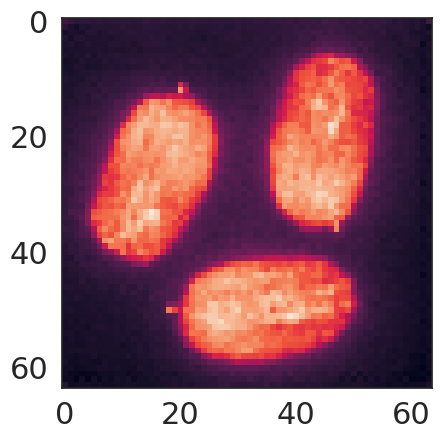

In [24]:
import matplotlib.pyplot as plt
plt.imshow(sample_img)

### Getting Info about pretraining
The pretraining is saved in sub_results in the result object

In [25]:
sub_res = result.sub_results
sub_res

{'multi_bulk.RNA': None,
 'multi_bulk.RNA2': None,
 'img.IMG': None,
 'pretrain.img.IMG': Result Object Public Attributes:
 ------------------------------
 latentspaces: TrainingDynamics object
 sample_ids: TrainingDynamics object
 reconstructions: TrainingDynamics object
 mus: TrainingDynamics object
 sigmas: TrainingDynamics object
 losses: TrainingDynamics object
 sub_losses: LossRegistry(_losses={'recon_loss': TrainingDynamics(), 'var_loss': TrainingDynamics(), 'anneal_factor': TrainingDynamics(), 'effective_beta_factor': TrainingDynamics()})
 preprocessed_data: Tensor of shape (0,)
 model: ImageVAEArchitecture
 model_checkpoints: TrainingDynamics object
 datasets: DatasetContainer(train=None, valid=None, test=None)
 new_datasets: DatasetContainer(train=None, valid=None, test=None)
 adata_latent: AnnData object with n_obs × n_vars = 0 × 0
 final_reconstruction: None
 sub_results: None
 sub_reconstructions: None
 embedding_evaluation: Empty DataFrame
 Columns: []
 Index: []}

## Xmodal_loss Visualization
Vibe coded provisory loss visualization

In [26]:
result.sub_losses.keys()
result.sub_losses.get("img.IMG.var_loss").get()


{0: {'train': array(28.50338336), 'valid': array(24.90473522)},
 1: {'train': array(28.56560083), 'valid': array(21.37103981)},
 2: {'train': array(28.48287589), 'valid': array(25.44539776)},
 3: {'train': array(28.56647479), 'valid': array(24.46195155)},
 4: {'train': array(28.30182495), 'valid': array(25.54544743)},
 5: {'train': array(28.61255791), 'valid': array(26.96455923)},
 6: {'train': array(28.15149568), 'valid': array(23.09380759)},
 7: {'train': array(28.68159353), 'valid': array(29.37980012)},
 8: {'train': array(28.28777693), 'valid': array(25.09383171)},
 9: {'train': array(28.38385583), 'valid': array(27.28512714)},
 10: {'train': array(28.43207533), 'valid': array(21.46298926)},
 11: {'train': array(28.58853955), 'valid': array(25.61038477)},
 12: {'train': array(28.37595115), 'valid': array(25.91572039)},
 13: {'train': array(28.53400541), 'valid': array(21.67880412)},
 14: {'train': array(28.1501266), 'valid': array(24.8001476)},
 15: {'train': array(28.29798943), 'v

Generating plots from mock result object...


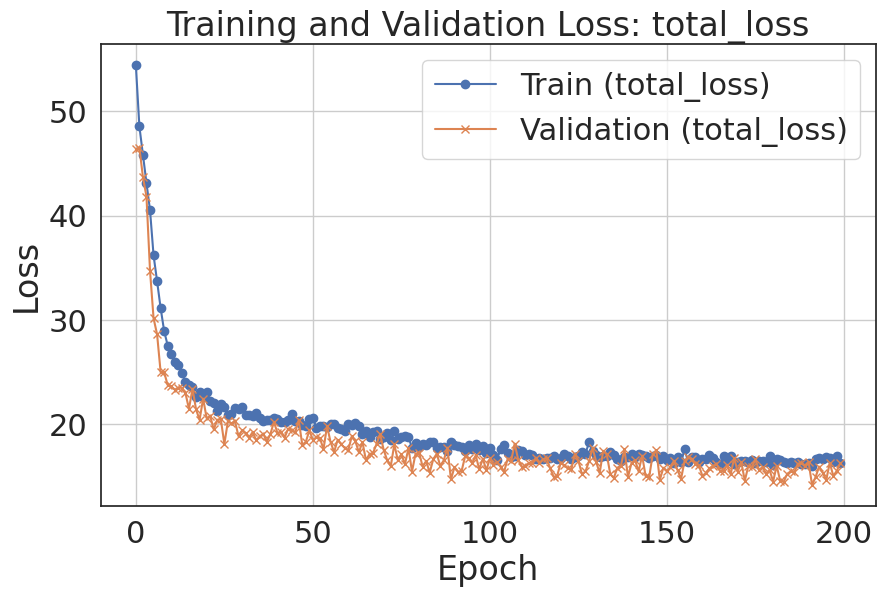

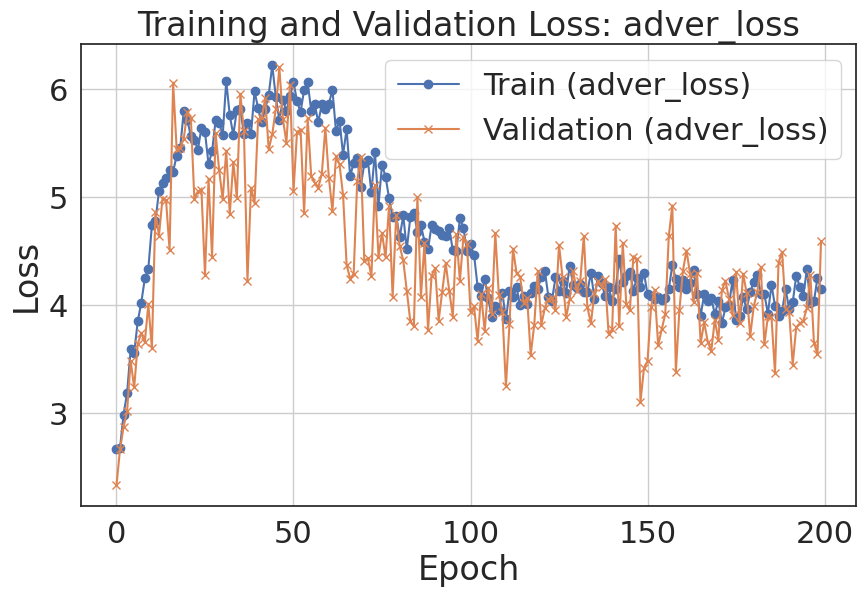

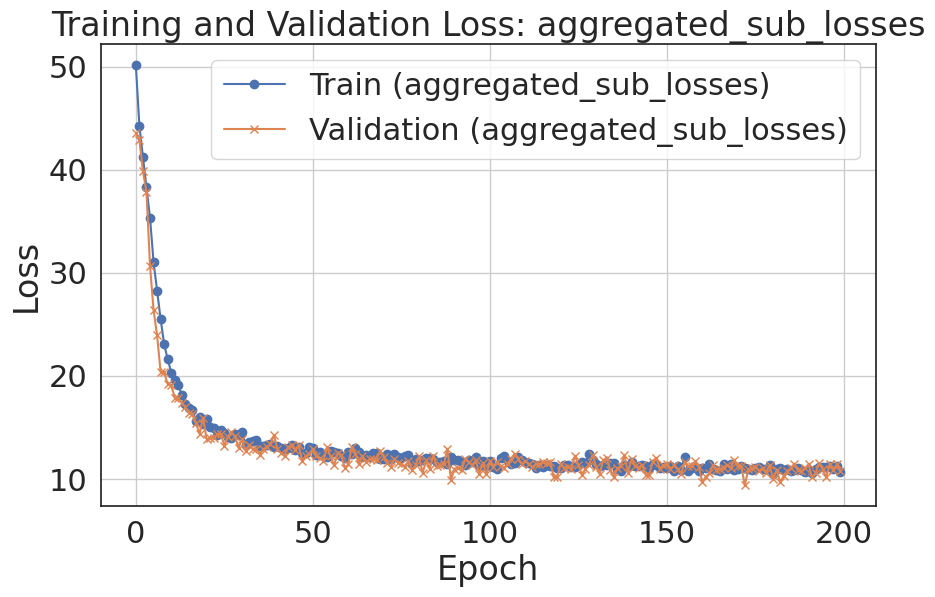

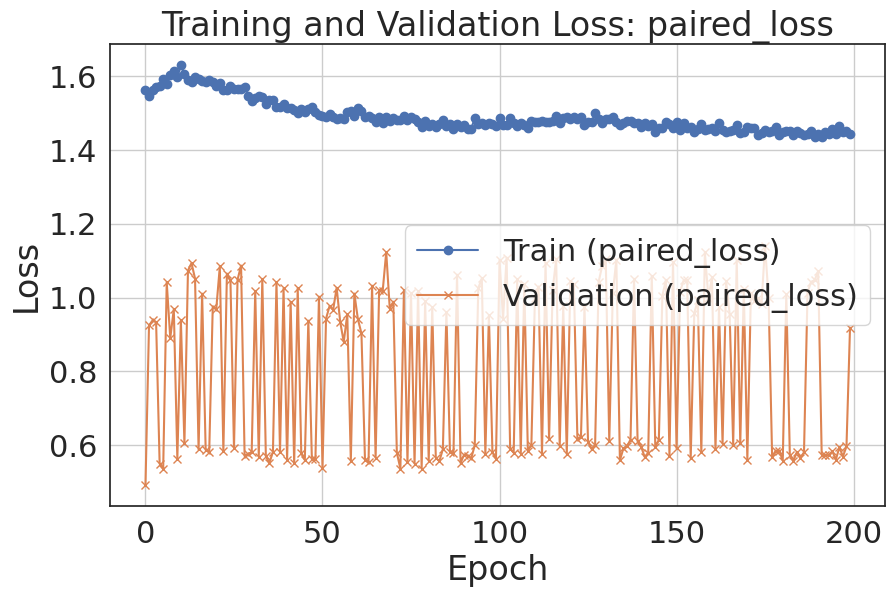

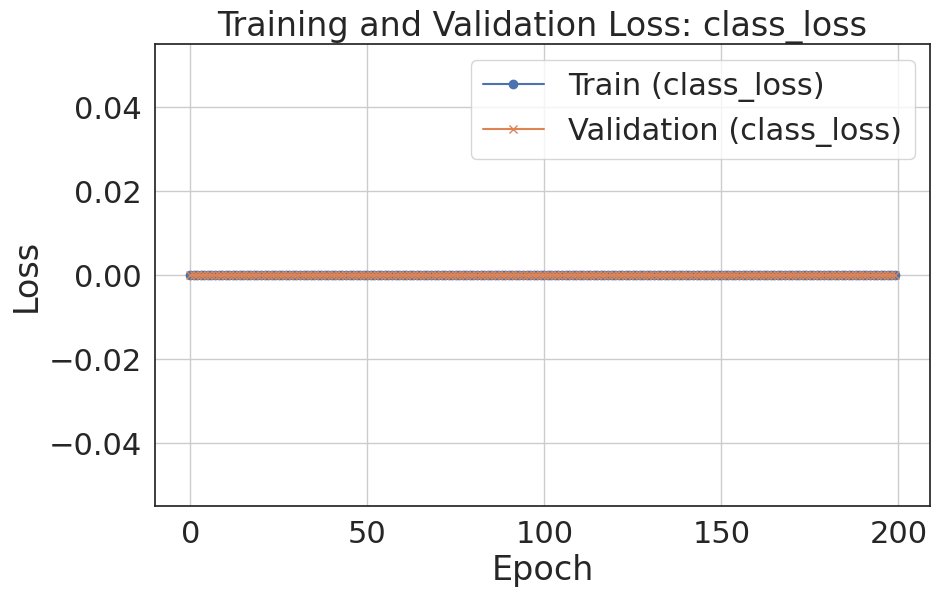

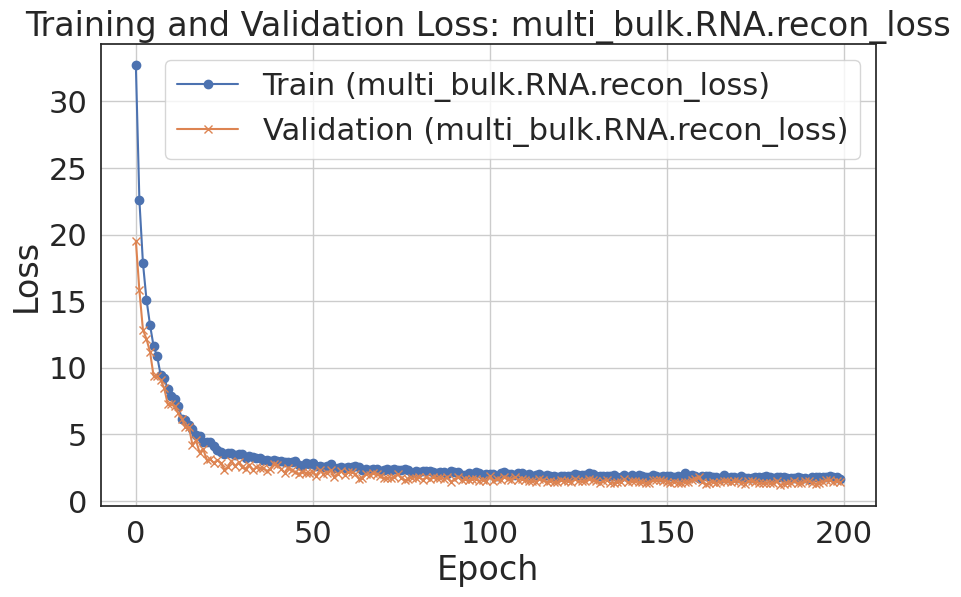

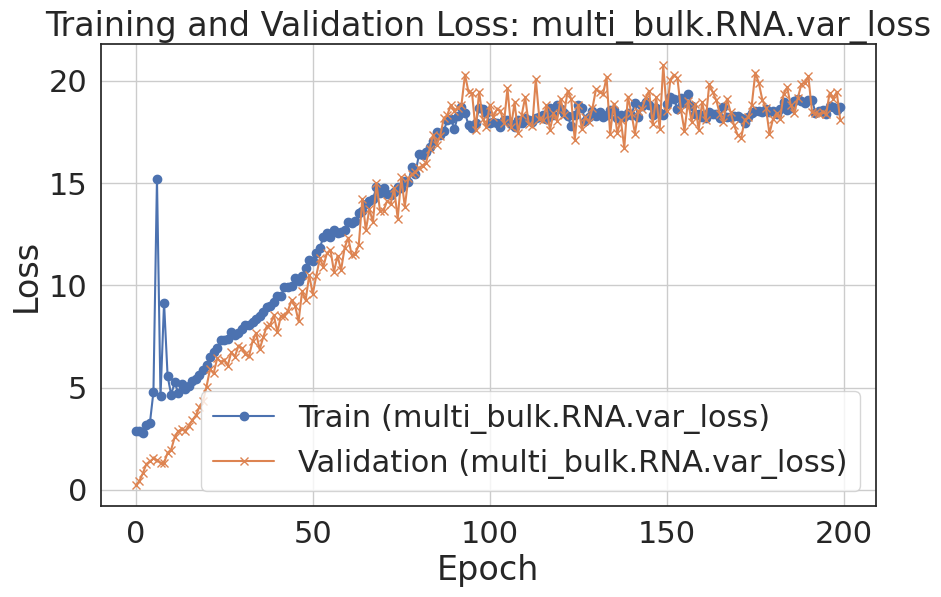

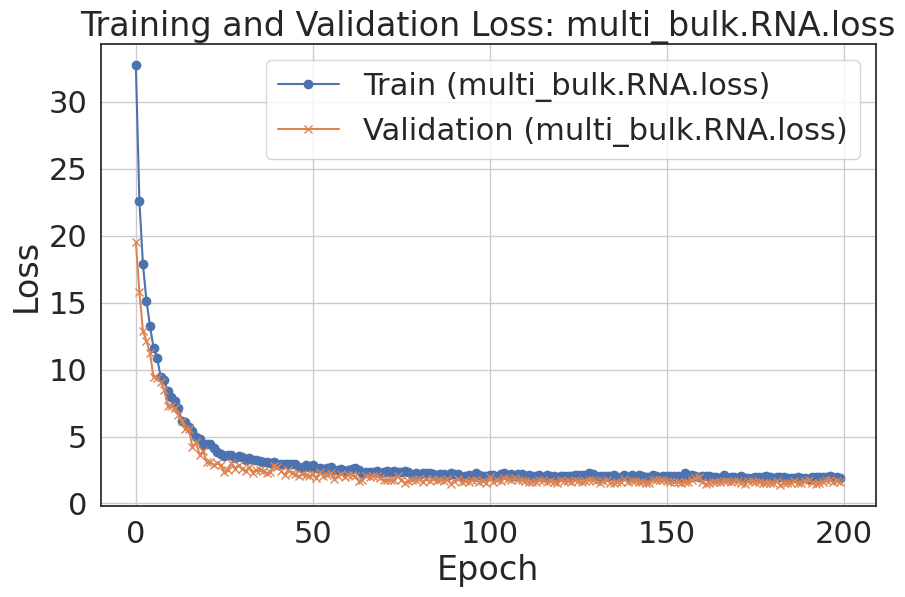

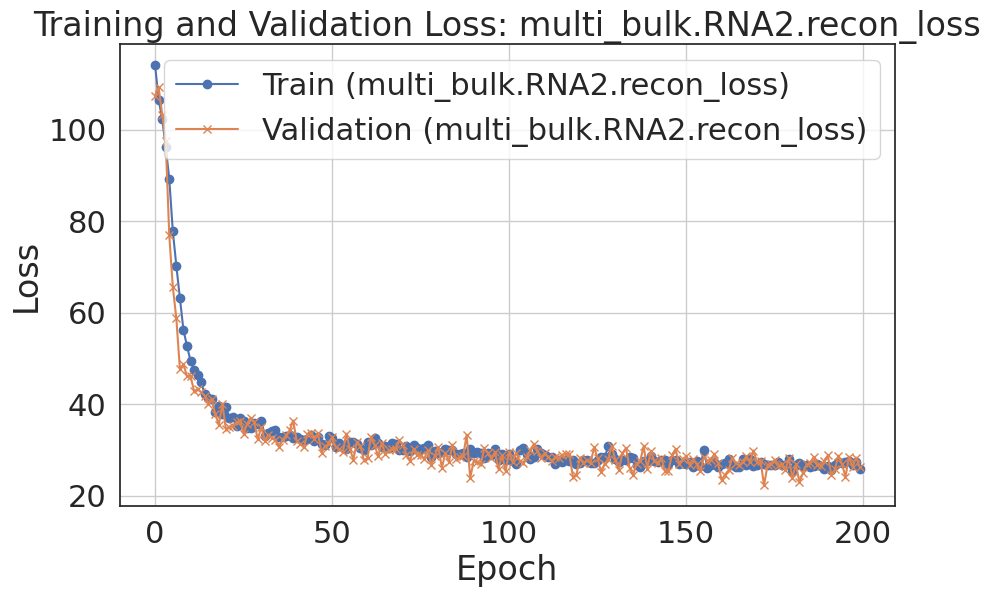

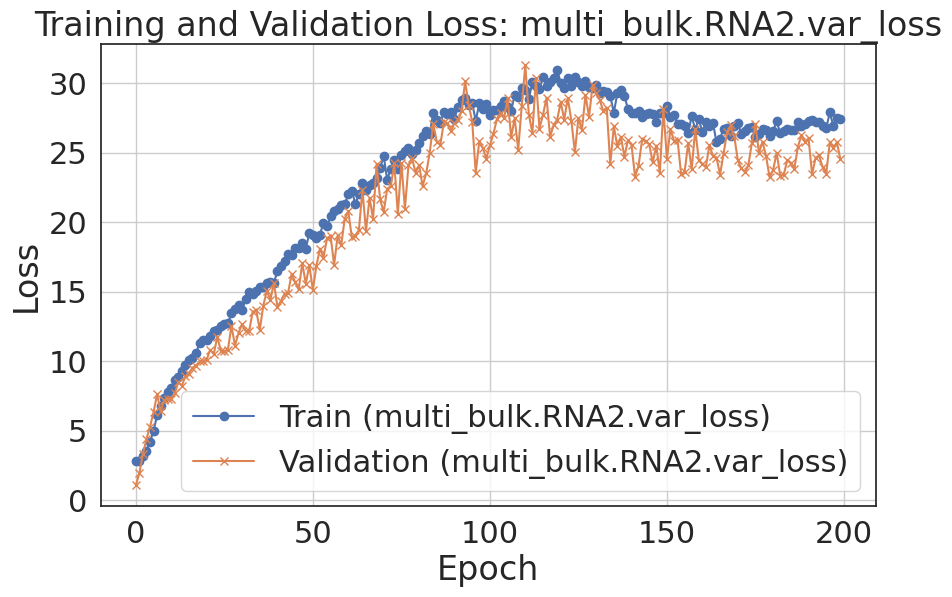

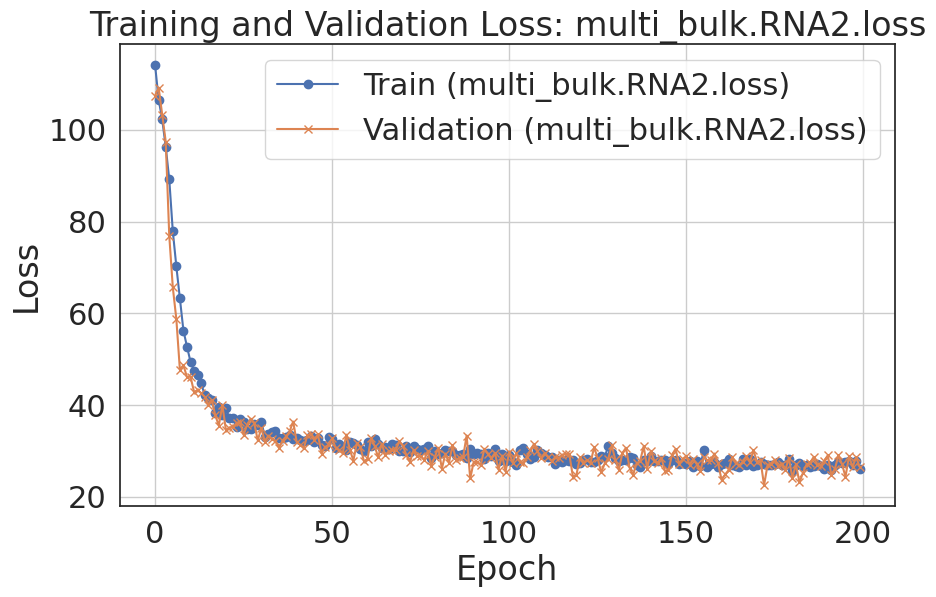

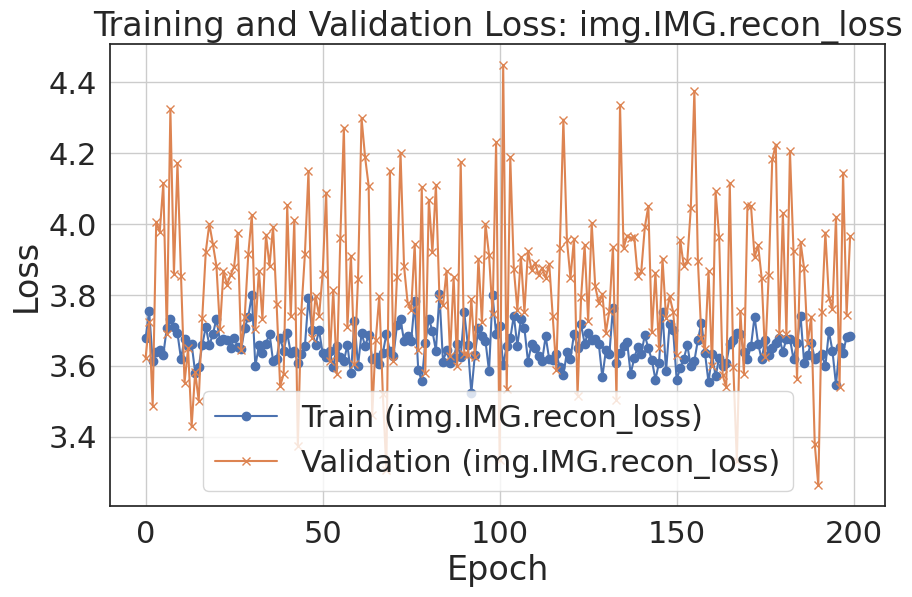

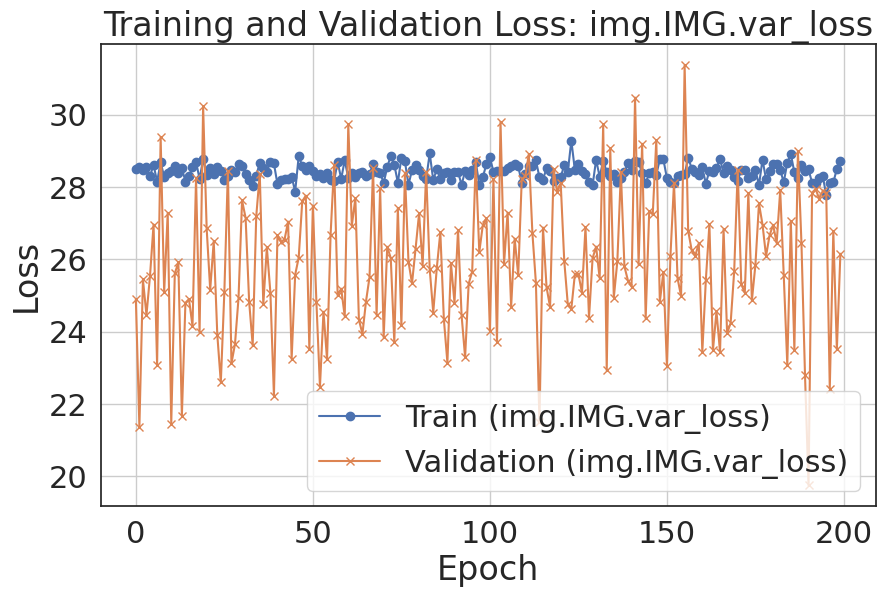

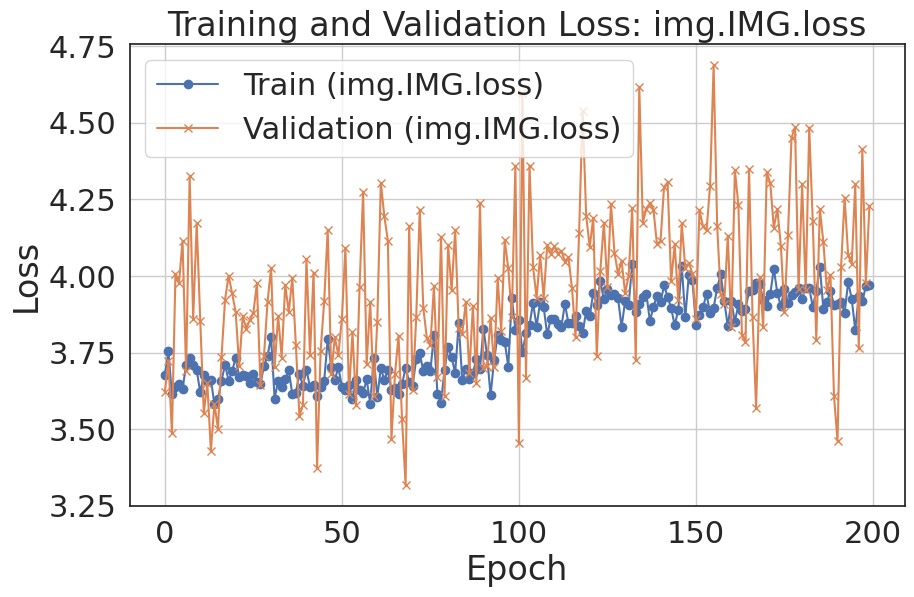

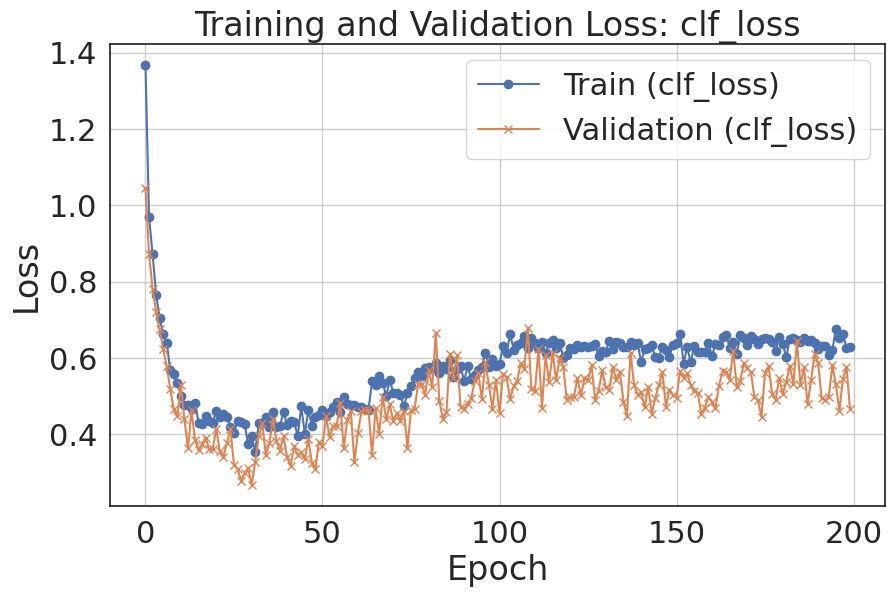

In [27]:
import matplotlib.pyplot as plt


def plot_losses(result):
    """
    Generates and displays plots for all relevant losses from a Result object.

    Args:
        result: Your custom result object containing the sub_losses attribute.
    """
    if not hasattr(result, "sub_losses"):
        print(
            "Error: The provided result object does not have a 'sub_losses' attribute."
        )
        return

    # 1. Get all loss keys and filter out the factors
    all_loss_keys = result.sub_losses.keys()
    keys_to_plot = [key for key in all_loss_keys if not key.endswith("_factor")]

    if not keys_to_plot:
        print("No valid loss keys found to plot.")
        return

    # 2. Iterate through each loss and create a plot
    for loss_name in keys_to_plot:
        try:
            # Retrieve the nested dictionary for the current loss
            loss_data = result.sub_losses.get(loss_name).get()

            # 3. Unpack the data into lists for plotting
            epochs = sorted(loss_data.keys())
            train_losses = [loss_data[epoch]["train"] for epoch in epochs]

            # Check if validation data exists before trying to plot it
            has_valid_data = all("valid" in loss_data[epoch] for epoch in epochs)
            if has_valid_data:
                valid_losses = [loss_data[epoch]["valid"] for epoch in epochs]

            # 4. Create the plot
            plt.figure(figsize=(10, 6))
            plt.plot(epochs, train_losses, "o-", label=f"Train ({loss_name})")
            if has_valid_data:
                plt.plot(epochs, valid_losses, "x-", label=f"Validation ({loss_name})")

            plt.title(f"Training and Validation Loss: {loss_name}")
            plt.xlabel("Epoch")
            plt.ylabel("Loss")
            plt.legend()
            plt.grid(True)
            plt.show()

        except (AttributeError, TypeError, KeyError) as e:
            print(f"Could not plot '{loss_name}'. Error retrieving data: {e}")


# This is a mock setup to demonstrate how to use the function.
print("Generating plots from mock result object...")
plot_losses(result)

## Imagix
If we want to use a standard image vae, we can use the Imagix pipeline. Note that only one image dataset is allowed here
**NOTE**:
set the datacase in config to DataCase.IMG_TO_IMG

In [28]:
import autoencodix as acx
from autoencodix.utils.default_config import (
    DefaultConfig,
    DataConfig,
    DataCase,
    DataInfo,
)
import os

IMGROOT = os.path.join("data/images/ALY-2_SYS721/")
IMGMAPPING = os.path.join("data/ALY-2_SYS721_mappings.txt")
NUMFILE = os.path.join("data/AM3_NO2_raw_cell.tsv")

img_config2 = DefaultConfig(
    data_case=DataCase.IMG_TO_IMG,
    checkpoint_interval=10,
	loss_reduction = "sum",
    epochs=100,
	beta = 0.01,
	learning_rate=0.001,
	k_filter=1000,
	latent_dim=32,
    batch_size=32,
    data_config=DataConfig(
        data_info={
            "IMG": DataInfo(
                file_path=IMGROOT,
				scaling="MINMAX",
                data_type="IMG",
            ),
            "ANNO": DataInfo(
                file_path=IMGMAPPING,
                data_type="ANNOTATION",
            ),
        },
    ),
)

imagix = acx.Imagix(config=img_config2)
imagix.preprocess()
imagix.fit()

/home/ewald/Github/autoencodix_package/src/autoencodix/utils/default_config.py:460: UserWarning: Could not determine data_case: No numeric datasets found in data_info
  warnings.warn(f"Could not determine data_case: {str(e)}")
/home/ewald/Github/autoencodix_package/src/autoencodix/utils/_imgreader.py:251: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support sep=None with delim_whitespace=False; you can avoid this warning by specifying engine='python'.
  annotation = pd.read_csv(anno_file, sep=sep)


preprocessing
Checking data type: IMG
Found image type in config
current data info: file_path='data/images/ALY-2_SYS721/' data_type='IMG' scaling='MINMAX' filtering='VAR' sep=None extra_anno_file=None is_single_cell=False min_cells=0.05 min_genes=0.02 selected_layers=['X'] is_X=False normalize_counts=True log_transform=True k_filter=20 img_root=None img_width_resize=64 img_height_resize=64 translate_direction=None pretrain_epochs=0
Checking data type: ANNO
Given image size is possible, rescaling images to: 64x64
reading annotation file: data/ALY-2_SYS721_mappings.txt
 n_samples: {'multi_sc': {'multi_sc': 0}, 'multi_bulk': {'multi_bulk': 0}, 'annotation': {'annotation': 0}, 'img': {'IMG': 260}, 'from_modality': {}, 'to_modality': {}, 'paired_count': {'paired_count': 260}}
Converting 182 images to torch.float32 tensors...
Converting 52 images to torch.float32 tensors...
Converting 26 images to torch.float32 tensors...
Epoch 1 - Train Loss: 259874174.0000
Sub-losses: recon_loss: 259874174

In [29]:
imagix.predict()

Result Object Public Attributes:
------------------------------
latentspaces: TrainingDynamics object
sample_ids: TrainingDynamics object
reconstructions: TrainingDynamics object
mus: TrainingDynamics object
sigmas: TrainingDynamics object
losses: TrainingDynamics object
sub_losses: LossRegistry(_losses={'recon_loss': TrainingDynamics(), 'var_loss': TrainingDynamics(), 'anneal_factor': TrainingDynamics(), 'effective_beta_factor': TrainingDynamics()})
preprocessed_data: Tensor of shape (0,)
model: ImageVAEArchitecture
model_checkpoints: TrainingDynamics object
datasets: DatasetContainer(train=<autoencodix.data._image_dataset.ImageDataset object at 0x7b62ba994cd0>, valid=<autoencodix.data._image_dataset.ImageDataset object at 0x7b62ba9948b0>, test=<autoencodix.data._image_dataset.ImageDataset object at 0x7b62ba994a00>)
new_datasets: DatasetContainer(train=None, valid=None, test=None)
adata_latent: AnnData object with n_obs × n_vars = 52 × 32
    uns: 'var_names'
final_reconstruction: <au

In [30]:
r2 = imagix.result
r2.final_reconstruction
sample_img = r2.final_reconstruction.data[0, :, :, :]
sample_img = sample_img.squeeze()

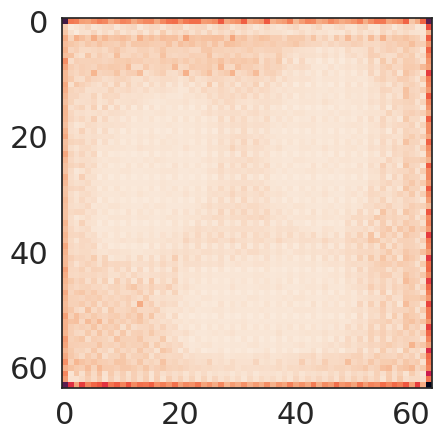

In [31]:
import matplotlib.pyplot as plt

plt.imshow(sample_img.numpy())